In [ ]:
%tensorflow_version 1.x
import os
from PIL import Image, ImageOps, ImageFont, ImageDraw
import numpy as np
import random

# Clear out the results folder if it exists
if os.path.exists("results"):
  !rm -r results

# Pick a number, any number
seed = random.randint(0,100000)
seed_arg = "--seeds="

for i in range(20):
  seed_arg += str(seed+i) + ","
seed_arg += str(seed+20)

# Generate the images
!python stylegan2-ada/generate.py $seed_arg --trunc=1.25  \
  --outdir results --network=network-snapshot-000188.pkl

# Initialize the x and y arrays
x = np.linspace(0, 849, 850)
y = np.empty(shape=(850))

# Read the file containing the paintings and aspect ratios
info_file = open('painting_info.txt', 'r')
lines = info_file.readlines()

# Use this font
fnt = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', 20)

# Loop through the lines, capturing the aspect ratio in the y array
count = 0
for line in lines:
  parts = line.split(' ')
  if len(parts) == 2 and len(parts[1]) > 0:
    y[count] = parts[1]
  count += 1

# Sort the values
y = np.sort(y)

# Use piecewise linear interpolation
def get_aspect_ratio():
  input_x = np.random.rand(1)*850
  y_interp = np.interp(input_x, x, y)
  return y_interp[0]

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

# Get all the image file names
image_files = []
for root, dirs, files in os.walk("results"):
    files.sort()
    for file in files:
        if file.endswith(".png"):
             image_files.append(os.path.join(root, file))

# Generate a grid of thumbnails
aspect_ratios = []
size = 250
count = 0
for j in range(0, 3):
  for i in range(0, 7):
    tile = Image.open(image_files[count])
    aspect = get_aspect_ratio()
    aspect_ratios.append(aspect)

    if aspect<1:
      newsize = (int(size * aspect), size)
    else:
      newsize = (size, int(size / aspect))

    tile = tile.resize(newsize)

    delta_w = size - newsize[0] + 20
    delta_h = size - newsize[1] + 30
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    tile = ImageOps.expand(tile, padding, fill = (255, 255, 255))

    draw = ImageDraw.Draw(tile)
    draw.text((0, 0), str(count+1), font=fnt, fill=(0,0,0))

    if i%7 == 0:
      row = tile
    else:
      row = get_concat_h(row, tile)

    count += 1

  if j%4 == 0:
    group = row
  else:
    group = get_concat_v(group, row)

# Show the thumbnails
group

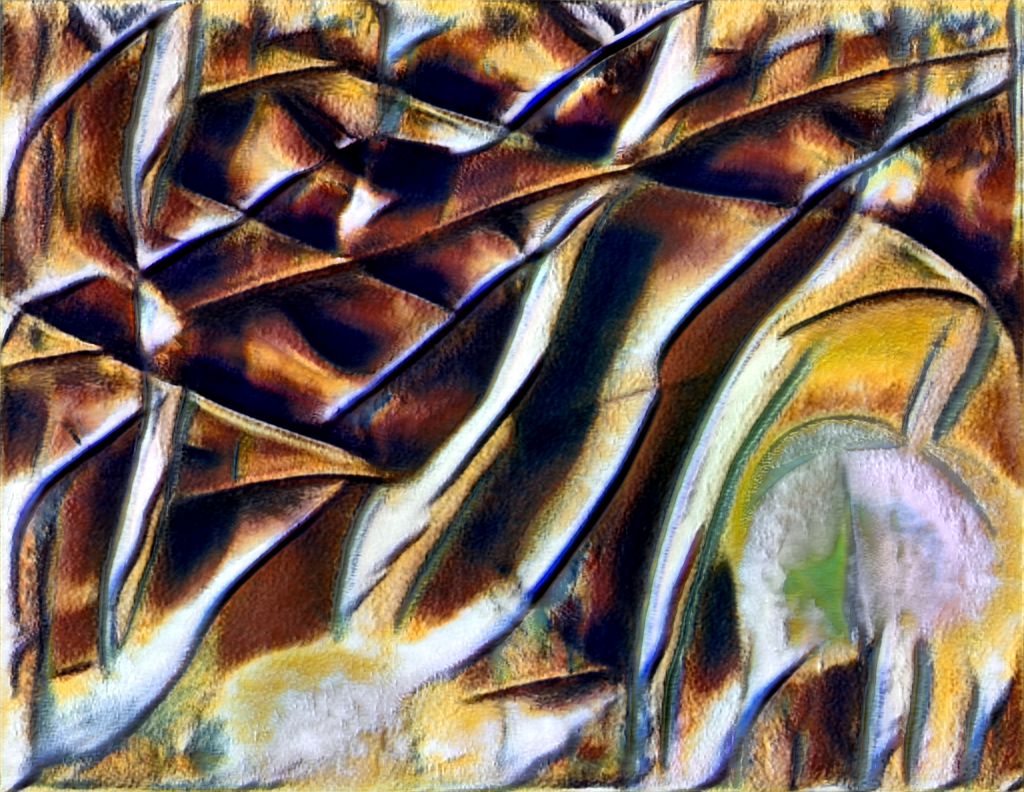

In [ ]:
chosen_thumbnail = 1 #@param {type:"slider", min:1, max:21, step:1}
image = Image.open(image_files[chosen_thumbnail-1])
size = 1024
aspect = aspect_ratios[chosen_thumbnail-1]

if aspect<1:
  newsize = (int(size * aspect), size)
else:
  newsize = (size, int(size / aspect))

resized = image.resize(newsize)
resized